# Predict pollution

## Parameters

In [1]:
from pathlib import Path

BASE_DIR = Path('/Users/efraflores/Desktop/EF/Diplo/data/04/amazon')
TRAIN_NAME = 'amazon_train.csv'
VAL_NAME = 'amazon_test.csv'
MAX_WORDS = 10000
MAX_SEQ = 50
EMBEDDING_DIM = 150
EPOCHS = 50
BATCH_SIZE = 5000

## Import

In [2]:
import pandas as pd

df = pd.read_csv(BASE_DIR.joinpath(TRAIN_NAME)).set_index('review_id')
df.sample()

,asin,name,rating,date,verified,title,body,helpfulVotes
review_id,,,,,,,,
26522,B06XYMCMHD,KAMI,4,"May 17, 2018",True,Excelente,Bien,NaN


## Functions

### Clean text

In [3]:
#Uncomment the following lines if it's the first time you run this packages
'''
!pip install emoji
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
'''
import re
import unicodedata
from emoji import demojize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lem = WordNetLemmatizer()

def clean_text(text, language='english', pattern="[^a-zA-Z\s]", add_stopw=[],
                lower=False, lemma=False, rem_stopw=False, unique=False, emoji=False):
    if emoji: text = demojize(text)
    cleaned_text = unicodedata.normalize('NFD',str(text).replace('\n',' \n ')).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern,' ',cleaned_text.decode('utf-8'),flags=re.UNICODE)
    cleaned_text = [(lem.lemmatize(word,pos='v') if lemma else word) for word in 
                    (cleaned_text.lower().split() if lower else cleaned_text.split())]
    if rem_stopw: cleaned_text = [word for word in cleaned_text if word not in 
                                  stopwords.words(language)+add_stopw]
    return ' '.join((set(cleaned_text) if unique else cleaned_text))

#Ex
ex = "I am going to run!!! I ran while I was running??? ..."
print('\nOriginal:\t\t',ex)
print('Basic cleaning:\t\t',clean_text(ex))
print('Changing the pattern:\t',clean_text(ex,pattern="[^a-zA-Z!\.]"))
print('Without stopwords:\t',clean_text(ex,rem_stopw=True))
print('Lower and lemma:\t',clean_text(ex,lower=True,lemma=True))
print('Super cleaning:\t\t',clean_text(ex,add_stopw=['go'],lower=True,rem_stopw=True,lemma=True,unique=True))
print("\nIt actually corrects the weird accents, example\n\tFROM:\t ThÈ ÉfrâïsMã's?...\n\tTO:\t",clean_text("ThÈ ÉfrâïsMa's?...",lower=True))
print("\nAnd now, it can translate emojis!!! 😍",clean_text('😍', emoji=True))


Original:		 I am going to run!!! I ran while I was running??? ...
Basic cleaning:		 I am going to run I ran while I was running
Changing the pattern:	 I am going to run!!! I ran while I was running ...
Without stopwords:	 I going run I ran I running
Lower and lemma:	 i be go to run i run while i be run
Super cleaning:		 run

It actually corrects the weird accents, example
	FROM:	 ThÈ ÉfrâïsMã's?...
	TO:	 the efraisma s

And now, it can translate emojis!!! 😍 smiling face with heart eyes


### Outliers

In [4]:
from sklearn.ensemble import IsolationForest

def outliers(data,cols):
    df = data.copy()
    outlier = IsolationForest(contamination=.04,n_jobs=-1)
    df['outlier'] = outlier.fit_predict(df[cols])
    df = df[df['outlier']!=-1].drop(columns = 'outlier')
    return df

### Confussion matrix

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def cm_keras(X, y, fit_model, label_encod=None, scale_to=1):
    y_real = [np.argmax(x) for x in y]
    y_predicted = [np.argmax(x).reshape(-1,)[0] for x in fit_model.predict(X)]

    if label_encod == None: pass
    else: 
        y_real = label_encod.inverse_transform(y_real)
        y_predicted = label_encod.inverse_transform(y_predicted)

    cm = pd.DataFrame(confusion_matrix(y_true=y_real, y_pred=y_predicted),
                    index=label_encod.classes_ if label_encod!=None else label_encod,
                    columns=label_encod.classes_ if label_encod!=None else label_encod).replace({0:np.nan}).T

    print('Accuracy de {:.2%}'.format(np.asarray(cm).trace()/len(y_test)))
    size = int(len(np.unique(y_real))/2)*scale_to
    fig, ax = plt.subplots(figsize=(size,size)) 
    sns.heatmap(pd.DataFrame([cm[col]/cm[col].sum() for col in cm.columns]), 
                annot = True,
                fmt = '.0%',
                cmap = 'Blues',
                linewidths = 0.5, 
                ax = ax)
    plt.show()
    return cm

### Full pipeline

In [6]:
def full_pipeline(data):
    df = data.copy()
    df.fillna({'title':'empty title', 'body':'empty body'}, inplace=True)
    df['text'] = df['title'].astype(str) + ' ' + df['body'].astype(str)
    df['clean_text'] = df['text'].map(lambda x: clean_text(x, lower=True, rem_stopw=True, lemma=True, emoji=True))
    df.fillna({'clean_text':'empty text'}, inplace=True)
    X = pad_sequences(tokenizer.texts_to_sequences(df['clean_text'].values), maxlen=MAX_SEQ)
    predictions = model.predict(X)
    return [le.inverse_transform([np.argmax(x)])[0] for x in predictions]

## Transform

### Full text

In [7]:
df.fillna({'title':'empty title', 'body':'empty body'}, inplace=True)
df['text'] = df['title'].astype(str) + ' ' + df['body'].astype(str)
df[['text']].sample(4)

,text
review_id,
61975,Excellent refurbished (or new??) iPhone se fro...
18516,best phone eva Fot me and i would say for many...
65349,Muy bueno Para el precio muy buen regalo y pro...
48253,Good Good


### Outliers

In [8]:
df['len'] = df['text'].str.split().str.len()
df['len'].describe()

count    50989.000000
mean        59.653729
std        120.063450
min          2.000000
25%         11.000000
50%         27.000000
75%         62.000000
max       5351.000000
Name: len, dtype: float64

In [9]:
df = outliers(df, ['len'])
df['len'].describe()

count    48956.000000
mean        41.959372
std         45.368490
min          2.000000
25%         10.000000
50%         26.000000
75%         55.000000
max        244.000000
Name: len, dtype: float64

### Clean text

In [10]:
# df['clean_text'] = df['text'].map(lambda x: clean_text(x, lower=True, rem_stopw=True, lemma=True, emoji=True))
# df.to_csv(BASE_DIR.joinpath(f'clean_{TRAIN_NAME}'))
# df[['text', 'clean_text']].sample(4)

In [11]:
df = pd.read_csv(BASE_DIR.joinpath(f'clean_{TRAIN_NAME}')).set_index('review_id')
df.fillna({'clean_text':'empty text'}, inplace=True)
df.sample()

,asin,name,rating,date,verified,title,body,helpfulVotes,text,len,clean_text
review_id,,,,,,,,,,,
4593,B079HB518K,I decided my sis and put it on my blog and she...,5,"December 5, 2019",True,Great gift,I bought this for my daughter. She says it’s t...,NaN,Great gift I bought this for my daughter. She ...,13,great gift buy daughter say best


## Model

### Tokenizer and Padding

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['clean_text'].values)
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')
X = pad_sequences(tokenizer.texts_to_sequences(df['clean_text'].values), maxlen=MAX_SEQ)
print(X[22])

Found 20118 unique tokens
[ 115   70 2266    5    1  112    2  289   90  573   66  219   73 3097
    1  138   66  312  227  416  541  500  863 4447    3   55  137   81
  241  336  158    1    5   81  541  500  112  211   21   44    5  167
   76  570   64  193   17  493  654  478]


### Target encoder

In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y = to_categorical(le.fit_transform(df['rating']))
print(le.classes_,'\n',y[22])

[1 2 3 4 5] 
 [0. 1. 0. 0. 0.]


### Train test split

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, train_size=0.77, shuffle=True)

### Arquitecture

In [15]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [16]:
# from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D

model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.1))
model.add(GRU(100, dropout=0.1, recurrent_dropout=0.1, activation="tanh"))
model.add(Dense(200, activation="relu"))
model.add(Dense(len(le.classes_), activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 150)           1500000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 150)           0         
_________________________________________________________________
gru (GRU)                    (None, 100)               75600     
_________________________________________________________________
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1005      
Total params: 1,596,805
Trainable params: 1,596,805
Non-trainable params: 0
_________________________________________________________________
None


#### Callbacks

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint = ModelCheckpoint(BASE_DIR.joinpath('models','amazon_model_{val_accuracy:.3f}.h5'),
                             save_best_only=True,
                             save_weights_only=False,
                             monitor='val_accuracy')

### Training

#### Compile

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Fit

In [19]:
training_history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Epoch 1/50
8/8 [==============================] - 28s 3s/step - loss: 1.5611 - accuracy: 0.5096 - val_loss: 1.4485 - val_accuracy: 0.5615
Epoch 2/50
8/8 [==============================] - 28s 3s/step - loss: 1.3073 - accuracy: 0.5625 - val_loss: 1.2268 - val_accuracy: 0.5615
Epoch 3/50
8/8 [==============================] - 24s 3s/step - loss: 1.1642 - accuracy: 0.5634 - val_loss: 1.1317 - val_accuracy: 0.5704
Epoch 4/50
8/8 [==============================] - 23s 3s/step - loss: 1.0800 - accuracy: 0.5878 - val_loss: 1.0515 - val_accuracy: 0.6076
Epoch 5/50
8/8 [==============================] - 23s 3s/step - loss: 0.9917 - accuracy: 0.6406 - val_loss: 0.9756 - val_accuracy: 0.6525
Epoch 6/50
8/8 [==============================] - 25s 3s/step - loss: 0.9019 - accuracy: 0.6746 - val_loss: 0.9021 - val_accuracy: 0.6774
Epoch 7/50
8/8 [==============================] - 28s 3s/step - loss: 0.8249 - accuracy: 0.7016 - val_loss: 0.8416 - val_accuracy: 0.7035
Epoch 8/50
8/8 [==================

#### Metrics

In [20]:
import cufflinks
cufflinks.go_offline()

metrics = pd.DataFrame(data = zip(training_history.history["loss"], training_history.history["val_loss"], training_history.history["accuracy"], training_history.history["val_accuracy"]), columns=["loss", "val_loss", "accuracy", "val_accuracy"])
metrics.iplot()

## Confussion Matrix

Accuracy de 71.31%


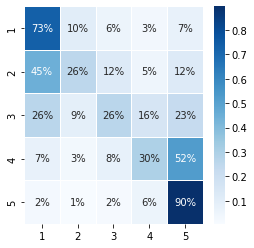

In [21]:
conf_matrix = cm_keras(X_test, y_test, model, label_encod=le, scale_to=2)

## Predict

In [22]:
val = pd.read_csv(BASE_DIR.joinpath(VAL_NAME)).set_index('review_id')
val['y_hat'] = full_pipeline(val)

In [23]:
val[['y_hat']].to_csv(BASE_DIR.joinpath(f'predict_{VAL_NAME}'))